In [12]:
# temp delete after

In [2]:
%matplotlib widget
import sys
from pathlib import Path

# add the root of the project to the path
sys.path.append(str(Path('../').resolve()))

# now we can import the module
from pptt import find_clicks
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile  # type: ignore
from scipy.signal import stft, find_peaks

from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')


In [3]:
fc = FileChooser('../data/')
fc.filter_pattern = ['*.vhdr']
fc.title = '<b>Select the BrainVision EEG recording containing the photodiode and trigger recordings</b>'
display(fc)

FileChooser(path='G:\github_projects\psychopy-timing-tests\data', filename='', title='<b>Select the BrainVisio…

In [4]:
eeg_data_file = fc.selected

In [5]:
fc2 = FileChooser('../data/')
fc2.filter_pattern = ['*.tsv']
fc2.title = '<b>Select the output timings TSV file from the test</b>'
display(fc2)


FileChooser(path='G:\github_projects\psychopy-timing-tests\data', filename='', title='<b>Select the output tim…

In [6]:
timing_data_file = fc2.selected

In [7]:
fc3 = FileChooser('../data/')
fc3.filter_pattern = ['*.wav']
fc3.title = '<b>Select the audio recording of the test</b>'
display(fc3)

FileChooser(path='G:\github_projects\psychopy-timing-tests\data', filename='', title='<b>Select the audio reco…

In [17]:
mic_recording = fc3.selected

In [18]:
# set channel types
misc_chan = [
    'PhotoDiodeDirect',
    'Stimtrak',
    'AFz',
    'F1',
    'F5',
    'FT7',
    'FC3',
    'C1',
]

# load brainvision data
raw = mne.io.read_raw_brainvision(eeg_data_file, misc=misc_chan, preload=True, verbose=False)

In [19]:
# load the timings
timings = pd.read_csv(Path(timing_data_file), sep='\t')  # type: ignore

In [20]:
# get the clicks in the audio recording
clicks = find_clicks(Path(mic_recording), threshold=0.2, save_data=False)  # type: ignore


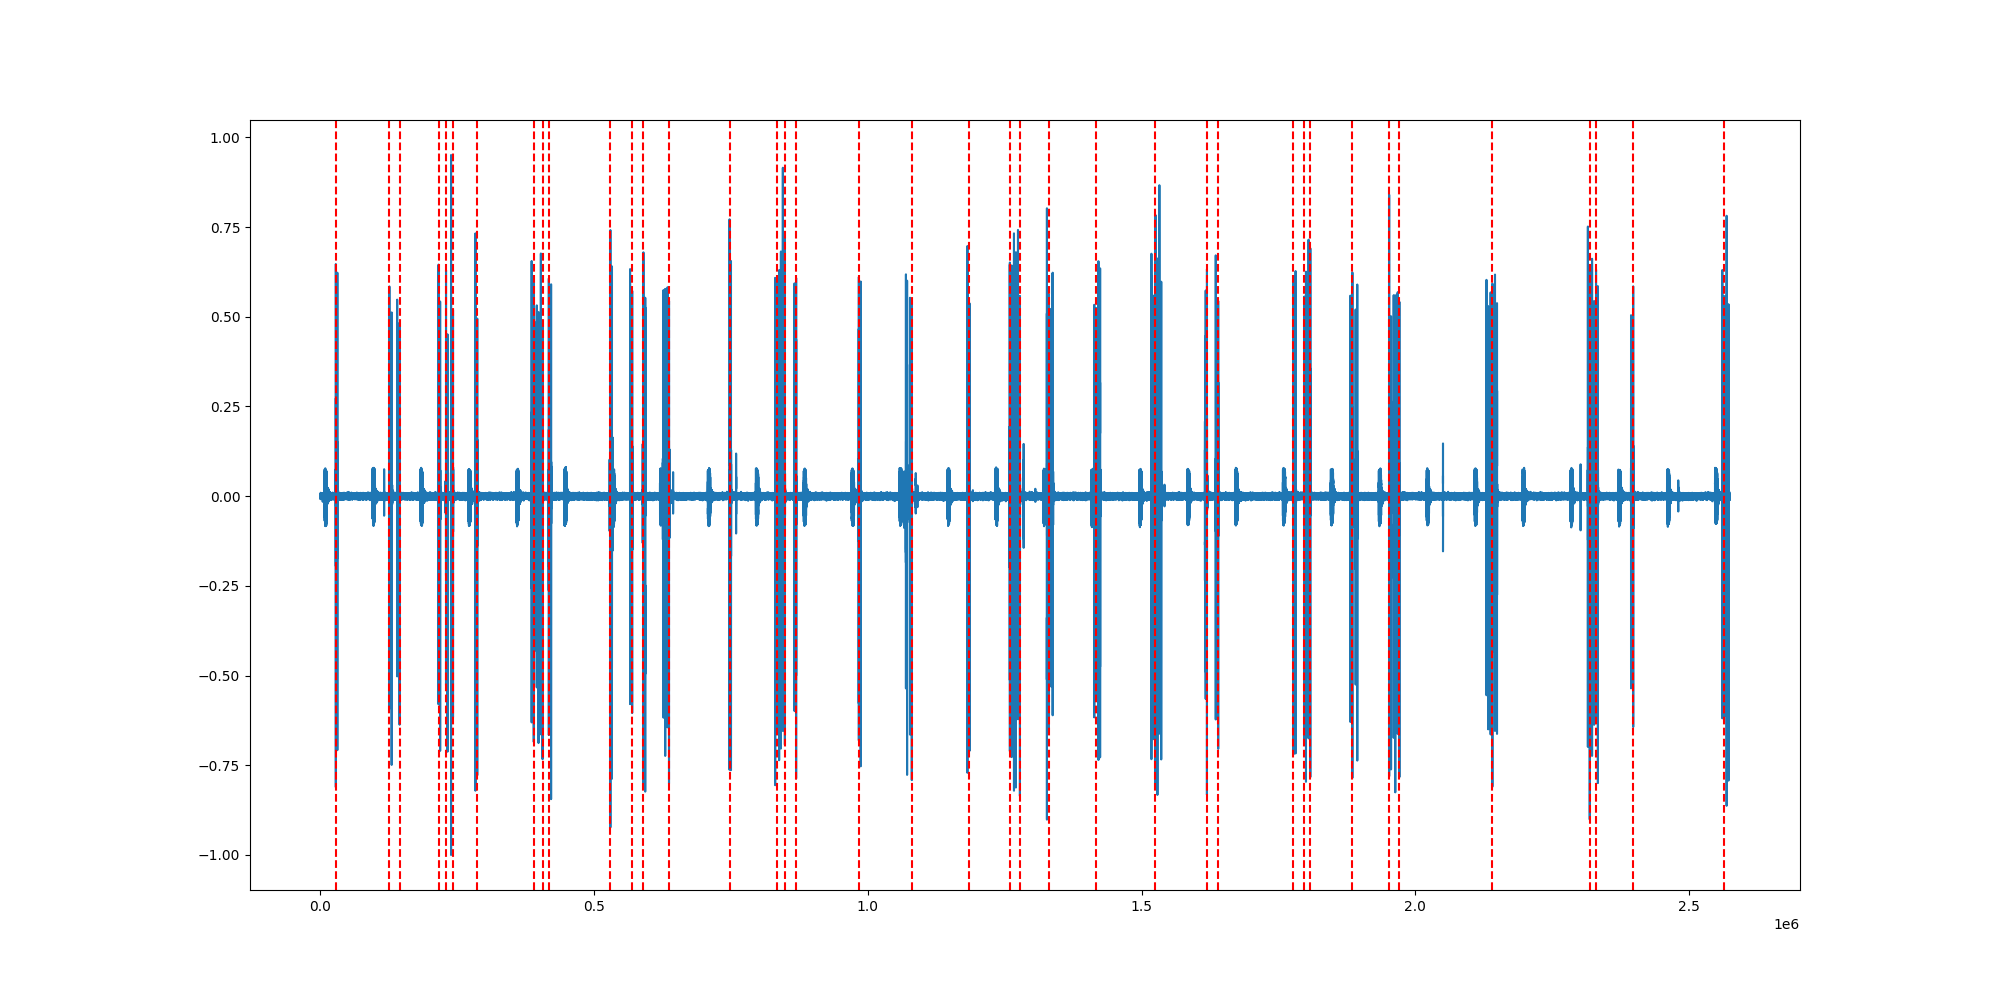

In [21]:
# plot click locations
sr, wav_data = wavfile.read(mic_recording)
# average if stereo
if wav_data.ndim > 1:
    wav_data = np.mean(wav_data, axis=1)

# normalize
wav_data = wav_data / np.max(np.abs(wav_data))

if clicks is None:
    raise ValueError('No clicks found')

click_locations = clicks["timestamp"] * sr
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(wav_data)), wav_data)
# add clicks as vertical lines
for click in click_locations:
    plt.axvline(click, color='r', linestyle='--')
plt.show()

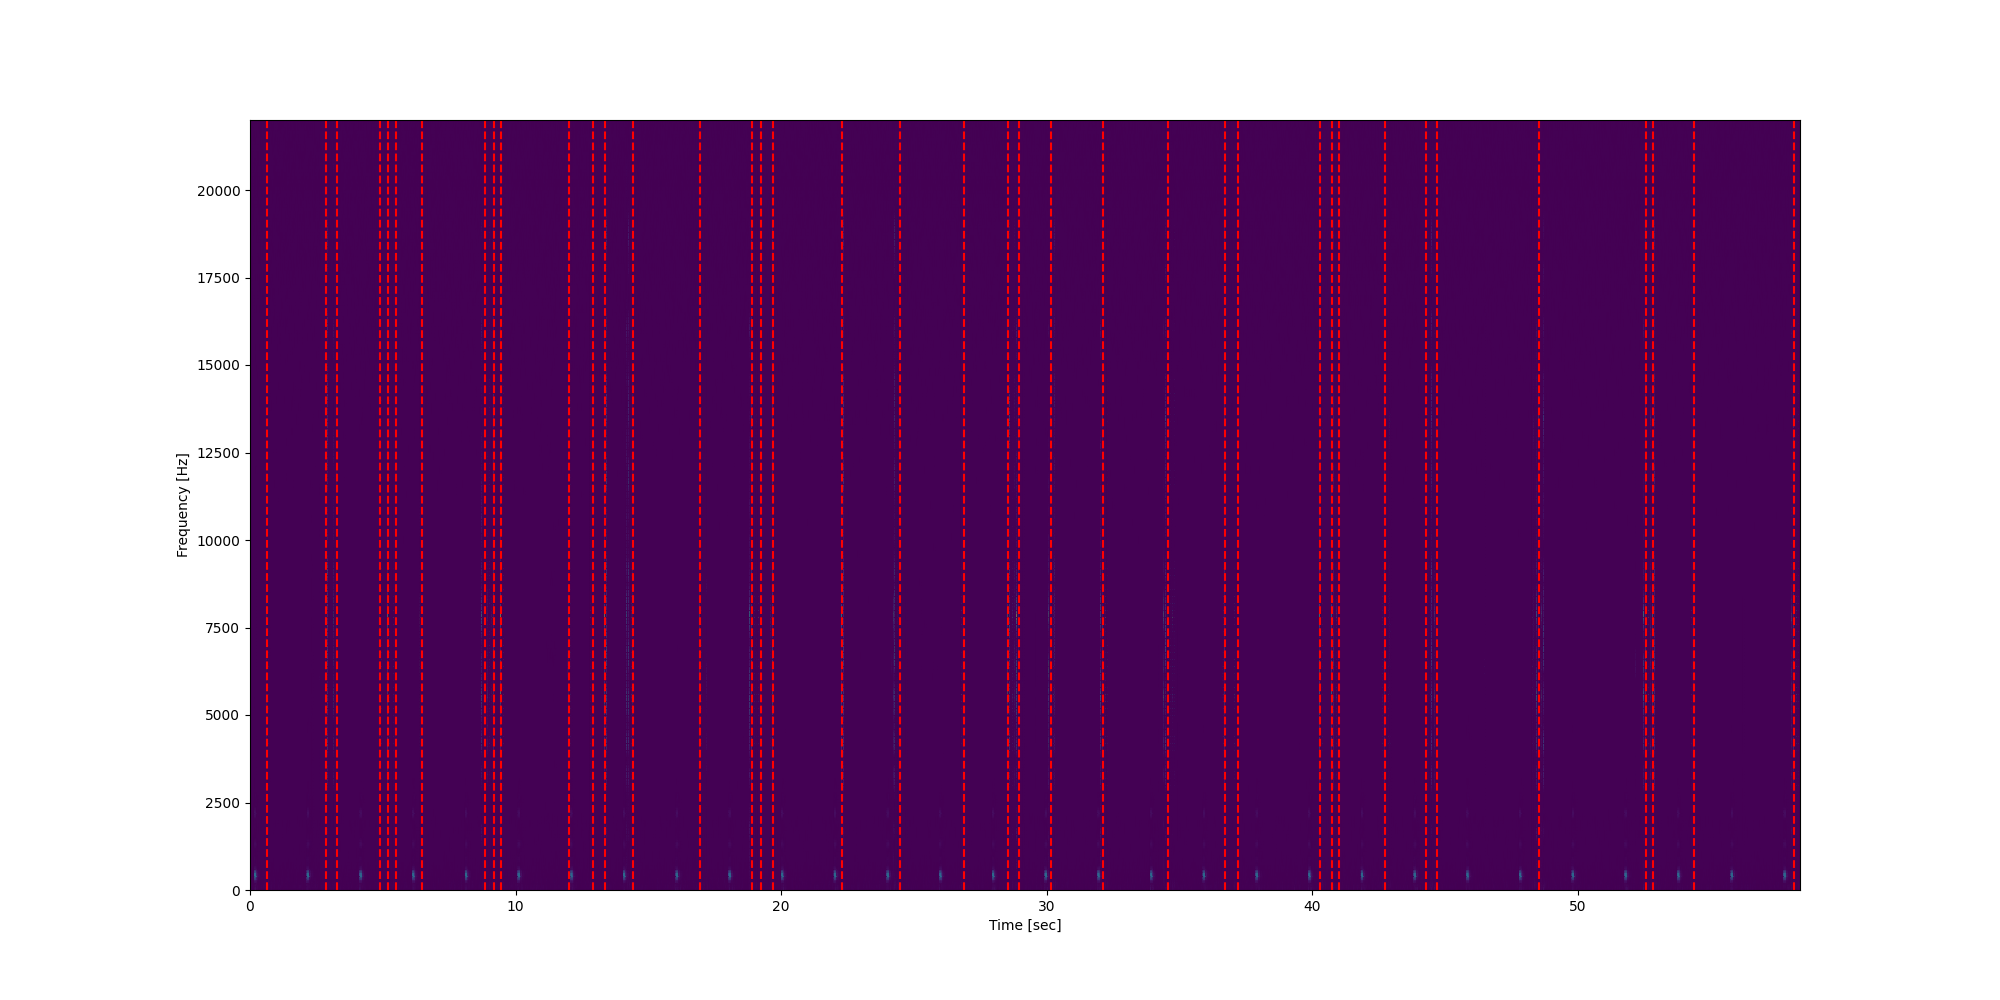

In [22]:
# plot as spectrogram
f, t, Zxx = stft(wav_data, fs=sr, nperseg=int(0.01*sr))

plt.figure(figsize=(20, 10))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
# add clicks as vertical lines
for click in click_locations:
    plt.axvline(click/sr, color='r', linestyle='--')
plt.show()


In [23]:
# display trigger information from eeg data
photodiode_ch = "PhotoDiodeDirect"
stimtrak_audio_ch = "Stimtrak"

# get segments names from the raw data
segments = set(raw.annotations.description)

eeg_picks = mne.pick_channels(raw.ch_names, [photodiode_ch, stimtrak_audio_ch])


In [24]:
segment_prefx = 'Response/R'
bit_friendly_names = [
    'Photodiode',
    'Mouse Click',
    'Audio Beep',
    'N/A',
    'N/A',
    'N/A',
    'N/A',
    'N/A',
]
segment_pin_map = {}
segment_event_map = {}
event_segment_map = {}
pin_count = 8
for segment in segments:
    if segment.startswith(segment_prefx):
        pin_states = []
        value = int(segment.split(" ")[-1])
        friendly_name = ''
        segment_event_map[segment] = value
        for pin in range(1, pin_count + 1):
            # bit flags
            pin_state = (value & (1 << pin)) >> pin
            pin_states.append(pin_state)
            if pin_state:
                friendly_name += bit_friendly_names[pin-1] + ' + '
        if friendly_name:
            friendly_name = friendly_name[:-3]
            event_segment_map[value] = friendly_name
        segment_pin_map[segment] = pin_states

# event_segment_map = {v: k for k, v in segment_event_map.items()}

segment_pin_map, segment_event_map, event_segment_map

({'Response/R  4': [0, 1, 0, 0, 0, 0, 0, 0],
  'Response/R  8': [0, 0, 1, 0, 0, 0, 0, 0],
  'Response/R 10': [1, 0, 1, 0, 0, 0, 0, 0],
  'Response/R  6': [1, 1, 0, 0, 0, 0, 0, 0],
  'Response/R  2': [1, 0, 0, 0, 0, 0, 0, 0]},
 {'Response/R  4': 4,
  'Response/R  8': 8,
  'Response/R 10': 10,
  'Response/R  6': 6,
  'Response/R  2': 2},
 {4: 'Mouse Click',
  8: 'Audio Beep',
  10: 'Photodiode + Audio Beep',
  6: 'Photodiode + Mouse Click',
  2: 'Photodiode'})

In [25]:
events = mne.events_from_annotations(raw, event_id=segment_event_map)


Used Annotations descriptions: ['Response/R  2', 'Response/R  4', 'Response/R  6', 'Response/R  8', 'Response/R 10']


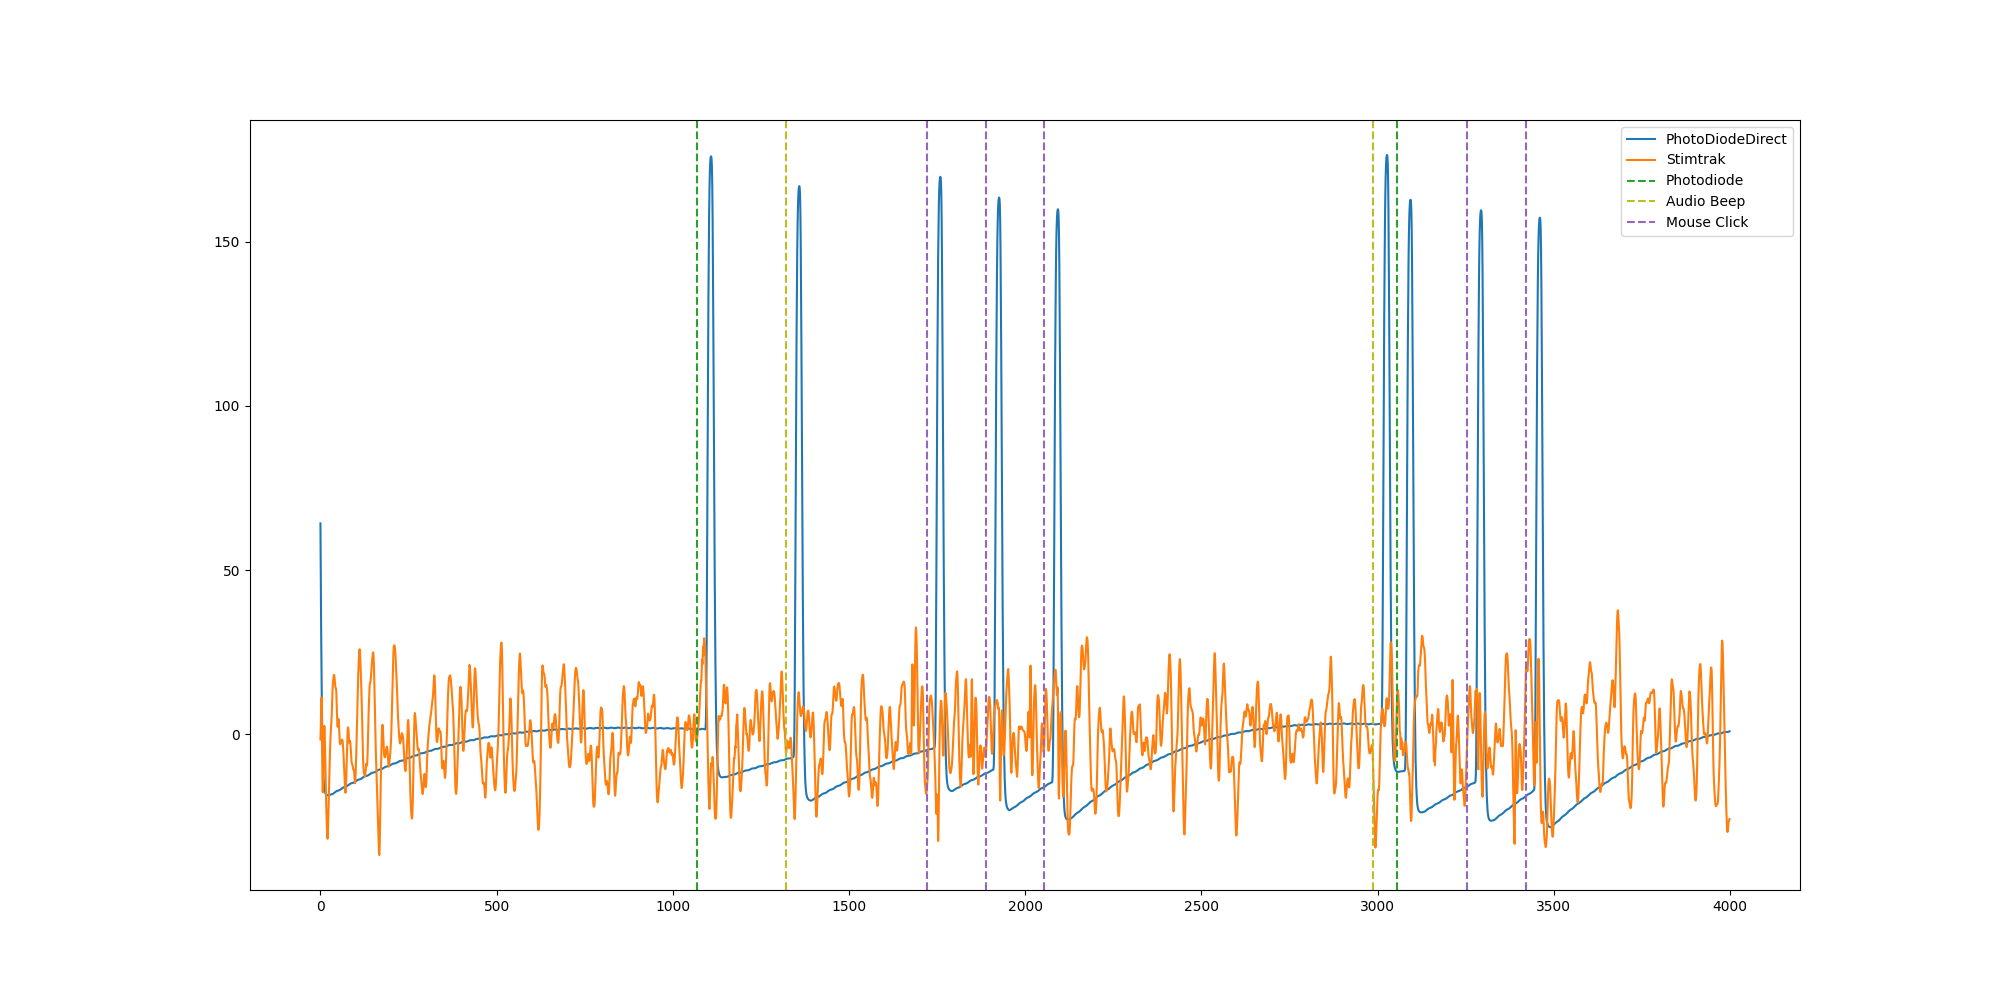

In [26]:
# get the photodiode and audio trigger data
photodiode_data = raw.get_data([eeg_picks[0]])
stimtrak_audio_data  = raw.get_data([eeg_picks[1]])

triggers = events[0]


photodiode_data = np.squeeze(photodiode_data)
stimtrak_audio_data = np.squeeze(stimtrak_audio_data)
# plot 1 second of data somewhere in the middle
# get the middle of the recording
middle = len(photodiode_data) // 2
length = int(raw.info['sfreq']*2)

start = middle - length
end = middle + length

plt.figure(figsize=(20, 10))
plt.plot(photodiode_data[start:end], label=photodiode_ch)
plt.plot(stimtrak_audio_data[start:end], label=stimtrak_audio_ch)
# add triggers
for trigger in triggers:
    if trigger[0] >= start and trigger[0] < end:
        plt.axvline(trigger[0] - start, linestyle='--', label=event_segment_map[trigger[2]], color=f'C{trigger[2]}')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


In [27]:
# get index of first trigger
first_trigger = triggers[0][0]
first_trigger


# line up the audio (it starts with the first trigger)
clicks_adjusted = clicks.copy()
clicks_adjusted['sample_index'] = ((clicks_adjusted['timestamp'] * sr) + first_trigger).astype(int)

clicks_adjusted

,timestamp,sample_index,frequency,amplitude,prominence,left_base,right_base
0,0.636440,37150,7800.0,0.096499,19.0,126,128
1,2.856463,135053,7800.0,0.092230,13.0,569,571
2,3.277415,153617,6500.0,0.036208,30.0,653,655
3,4.891066,224779,7800.0,0.093660,21.0,975,978
4,5.201769,238481,7800.0,0.084840,13.0,1037,1040
5,5.492426,251299,7500.0,0.031485,19.0,1095,1097
6,6.494694,295499,6500.0,0.044679,33.0,1295,1297
7,8.834989,398705,7500.0,0.034082,25.0,1762,1764
8,9.200816,414839,6900.0,0.039037,20.0,1835,1837
9,9.461406,426330,7800.0,0.092579,22.0,1887,1889


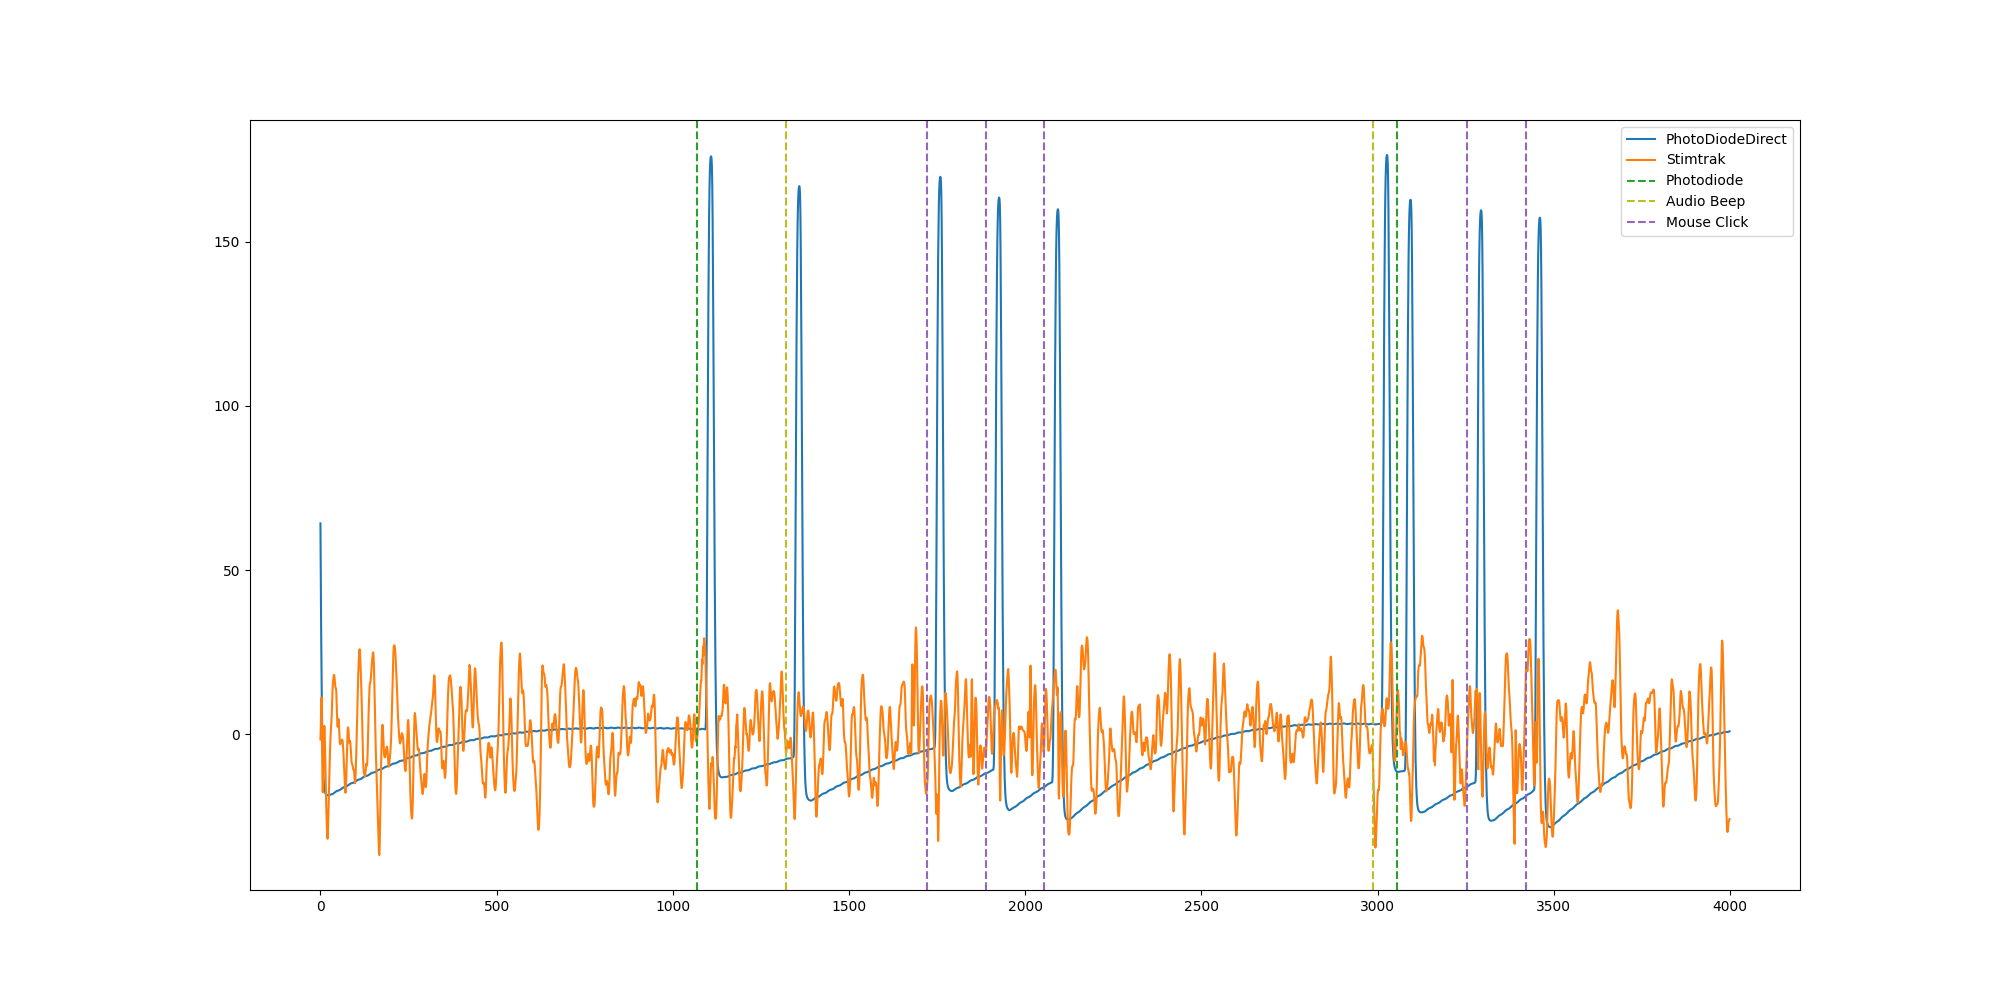

In [28]:
# now plot the clicks on the eeg data
plt.figure(figsize=(20, 10))
plt.plot(photodiode_data[start:end], label=photodiode_ch)
plt.plot(stimtrak_audio_data[start:end], label=stimtrak_audio_ch)
# add triggers
for trigger in triggers:
    if trigger[0] >= start and trigger[0] < end:
        plt.axvline(trigger[0] - start, linestyle='--', label=event_segment_map[trigger[2]], color=f'C{trigger[2]}')
# add clicks
for click in clicks_adjusted['sample_index']:
    if click >= start and click < end:
        plt.axvline(click - start, color='r', linestyle='--', label='Click (detected)')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


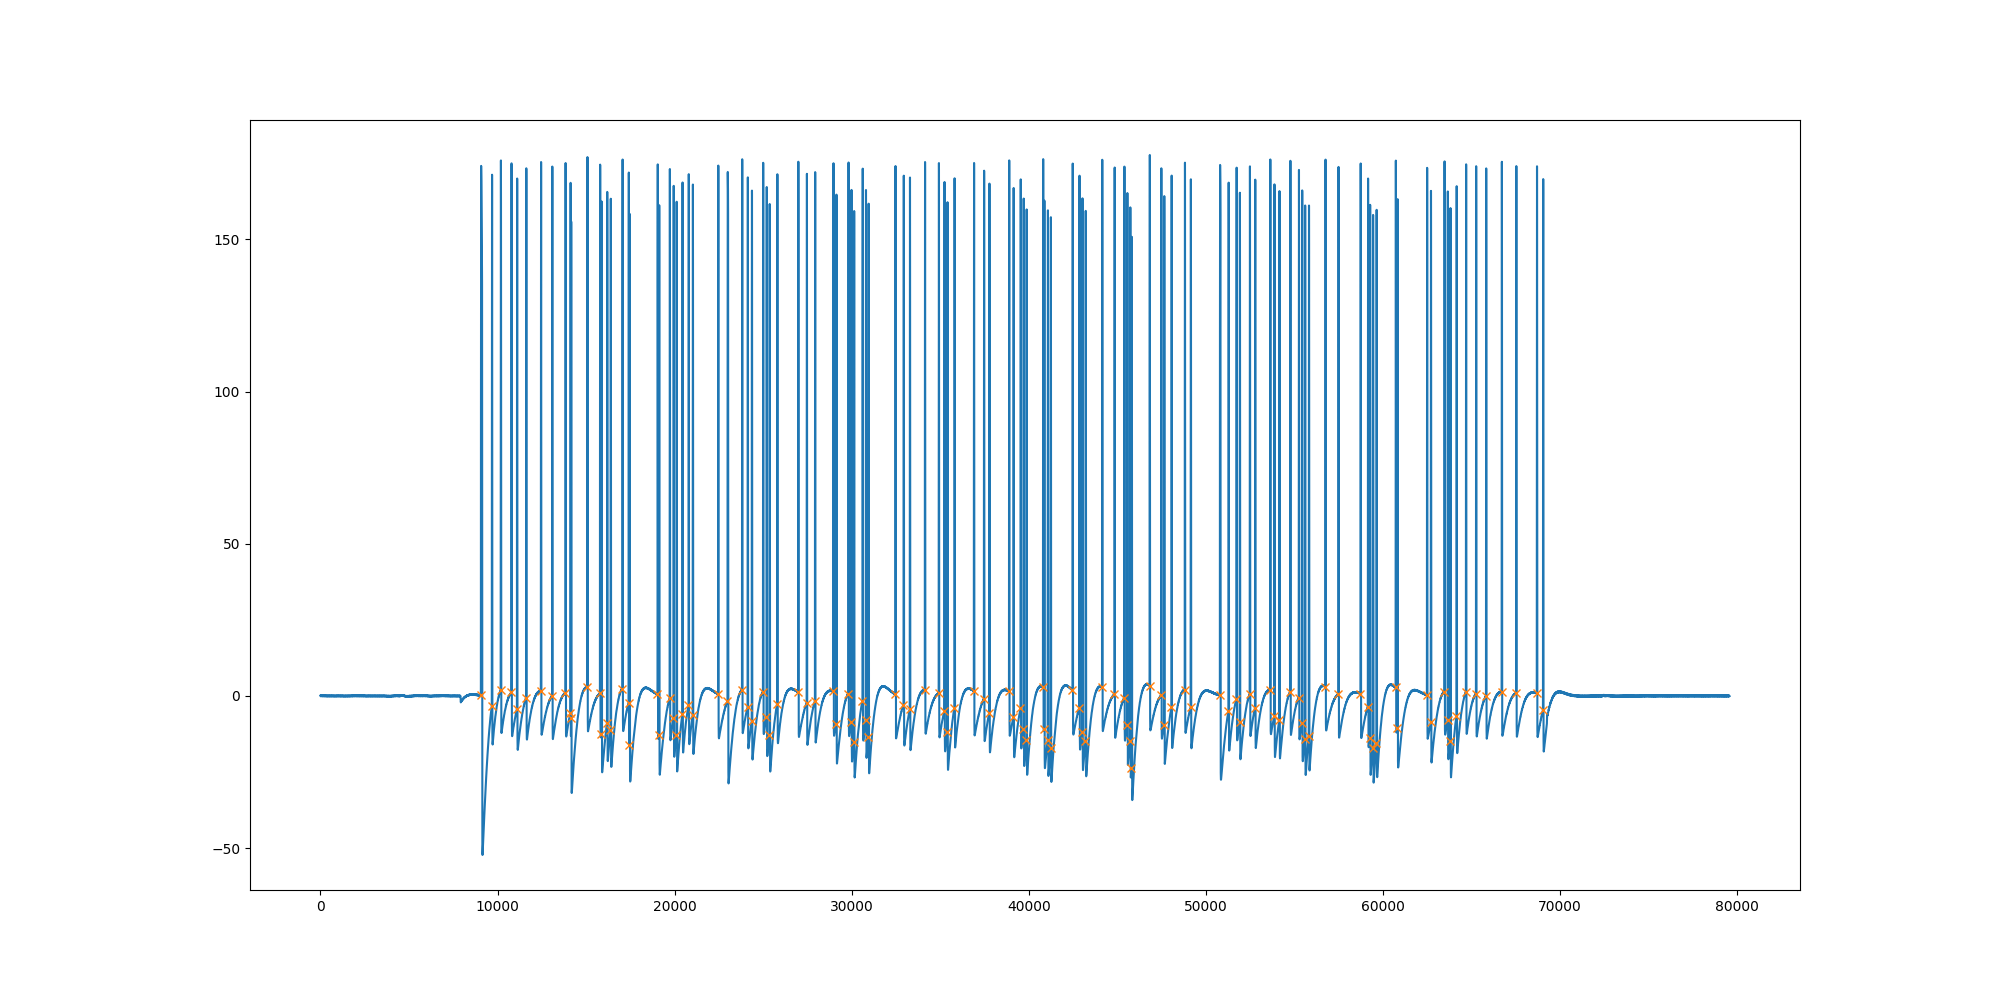

In [29]:
# get all the locations for the left bases of the photodiode pulses

photodiode_peaks, _ = find_peaks(photodiode_data, height=100)

# ~ 17 samples from left base to peak
base_peak_offset = 17
photodiode_peaks = photodiode_peaks - base_peak_offset

# plot the peaks on the photodiode data
plt.figure(figsize=(20, 10))
plt.plot(photodiode_data, label=photodiode_ch)
plt.plot(photodiode_peaks, photodiode_data[photodiode_peaks], 'x', label='Photodiode Peak (left base)')
plt.show()


In [30]:
# every event triggers a photodiode pulse, we can calculate the delay
# between the photodiode pulse and the trigger

# make sure there are equal numbers of events and photodiode pulses
if len(triggers) != len(photodiode_peaks):
    print('Number of triggers and photodiode pulses do not match')
    print(f'Number of triggers: {len(triggers)}')
    print(f'Number of photodiode pulses: {len(photodiode_peaks)}')

# it's possible that if there are less photodiode pulses it's because some triggers are extremely close together
# we can check for this
# get the difference between the triggers
trigger_diff = np.diff(triggers[:, 0])
# get the mean and std
mean_diff = np.mean(trigger_diff)
std_diff = np.std(trigger_diff)
min_diff = np.min(trigger_diff)
max_diff = np.max(trigger_diff)
mean_diff, std_diff, min_diff, max_diff

Number of triggers and photodiode pulses do not match
Number of triggers: 123
Number of photodiode pulses: 119


(491.2704918032787, 380.4270688358504, 16, 1669)

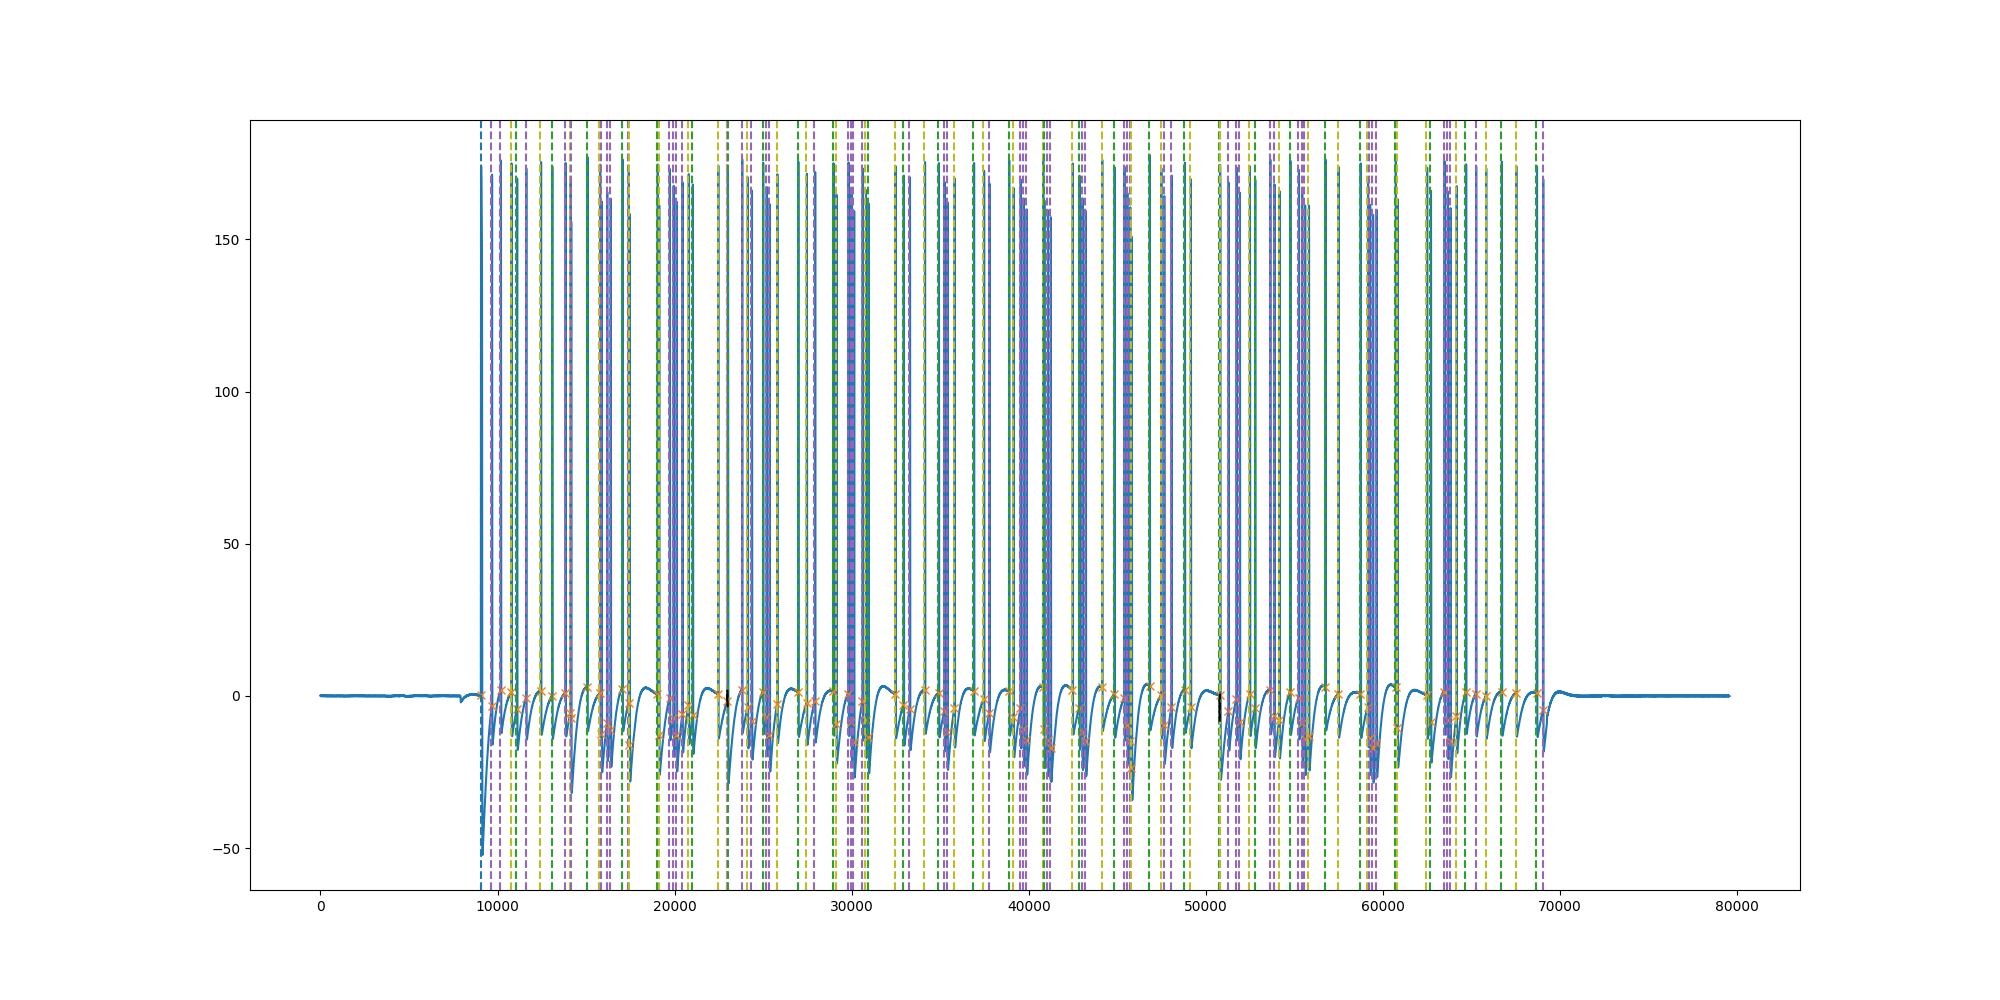

In [31]:
# because it takes 17 samples to get from left base to peak, then if the difference between triggers is less than 17 we can imply that it's the same pulse
# let's plot the photodiode signal and pulses for all triggers that are < close_sample_threshold
close_sample_threshold = (base_peak_offset - 2) * 2
plt.figure(figsize=(20, 10))
plt.plot(photodiode_data, label=photodiode_ch)
plt.plot(photodiode_peaks, photodiode_data[photodiode_peaks], 'x', label='Photodiode Peak (left base)')
# add triggers
for trigger in triggers:
    plt.axvline(trigger[0], linestyle='--', label=event_segment_map[trigger[2]], color=f'C{trigger[2]}')

# add lines between triggers that are less than close_sample_threshold samples apart
for i in range(len(triggers)-1):
    if trigger_diff[i] < close_sample_threshold:
        plt.plot([triggers[i][0], triggers[i+1][0]], [photodiode_data[photodiode_peaks[i]], photodiode_data[photodiode_peaks[i+1]]], 'k--')
plt.show()

In [32]:
# ok we need to remove the first peak and the first event because something clearly went wrong
photodiode_peaks_cropped = photodiode_peaks[1:]
triggers_cropped = triggers[1:]



# get triggers where difference betwen previous trigger is less than close_sample_threshold
trigger_diff = np.diff(triggers_cropped[:, 0])
close_trigger_count = np.sum(trigger_diff < close_sample_threshold)

# ensure count is equal if we remove the triggers
if len(triggers_cropped) - close_trigger_count != len(photodiode_peaks_cropped):
    print('Number of triggers and photodiode pulses do not match')
    print(f'Number of triggers (close removed): {len(triggers_cropped)}')
    print(f'Number of photodiode pulses: {len(photodiode_peaks_cropped)}')
else:
    print(f'Removing {close_trigger_count} close triggers will make the counts equal')


Removing 4 close triggers will make the counts equal


Close trigger indices: [27 28 84 85]


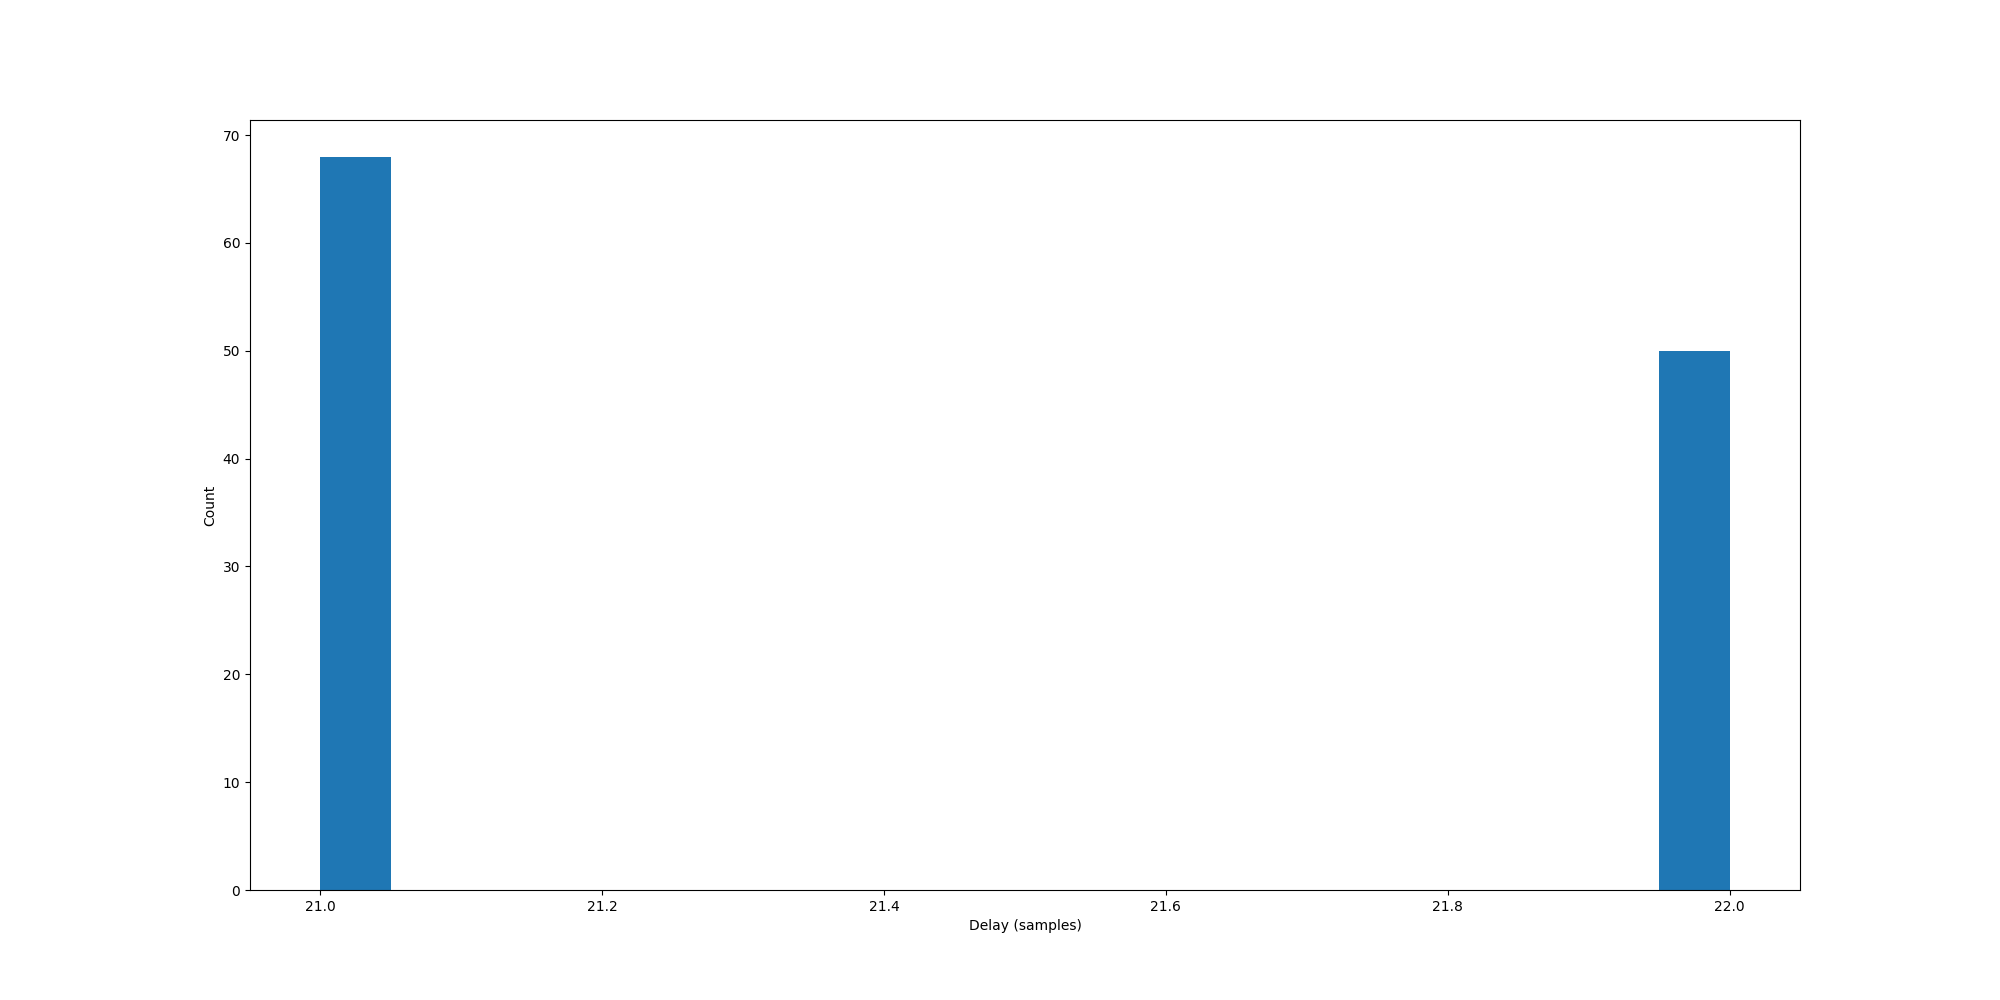

In [33]:
# remove the close triggers, only keeping the first of the group
# get the indices of the close triggers
close_trigger_indices = np.where(trigger_diff < close_sample_threshold)[0]
print(f'Close trigger indices: {close_trigger_indices}')
# add 1 to the indices because the output of np.diff is 1 less than the original array
close_trigger_indices = close_trigger_indices + 1
# remove the close triggers
triggers_cropped = np.delete(triggers_cropped, close_trigger_indices, axis=0)


# now we can calculate the delay between the photodiode pulse and the trigger
# we can do this by calculating the difference between the trigger and the photodiode pulse
# we can then plot the distribution of these delays
delays = photodiode_peaks_cropped - triggers_cropped[:, 0]

plt.figure(figsize=(20, 10))
plt.hist(delays, bins=20)
plt.xlabel('Delay (samples)')
plt.ylabel('Count')
plt.show()


In [34]:
# let's find where the delay is negative
negative_delays = np.argwhere(delays <= 0)
negative_delays = np.squeeze(negative_delays)

# for each positive delay plot 200 samples from the photodiode before and after the trigger
if negative_delays.shape[0] > 0:
    for i in negative_delays:
        plt.figure(figsize=(20, 10))
        plt.plot(list(range(-200, 200)),photodiode_data[photodiode_peaks_cropped[i]-200:photodiode_peaks_cropped[i]+200], label=photodiode_ch)
        plt.axvline(-delays[i], color='r', linestyle='--', label='Trigger')
        # include the peak marker
        plt.axvline(0, color='g', linestyle='--', label='Photodiode onset')
        plt.title(f'Delay: {delays[i]}')
        plt.legend()
        plt.show()

    # print the sample index
    for i in negative_delays:
        print(f'Event {i} has a negative delay of {delays[i]} samples, photodiode pulse at {photodiode_peaks_cropped[i]}, trigger at {triggers_cropped[i, 0]}')


In [35]:
# print the mean and std of the delays

mean_delay = np.mean(delays)
std_delay = np.std(delays)
min_delay = np.min(delays)
max_delay = np.max(delays)
mean_delay, std_delay, min_delay, max_delay

(21.423728813559322, 0.49414846566485604, 21, 22)

In [36]:
# print the values in ms
mean_delay_ms = mean_delay / sr * 1000
std_delay_ms = std_delay / sr * 1000
min_delay_ms = min_delay / sr * 1000
max_delay_ms = max_delay / sr * 1000
mean_delay_ms, std_delay_ms, min_delay_ms, max_delay_ms

(0.48579883930973516,
 0.011205180627321,
 0.47619047619047616,
 0.4988662131519275)